In [373]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.mixture import BayesianGaussianMixture
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import RobustScaler,PowerTransformer
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb


# Load the dataset
data = pd.read_csv(r"C:\Users\84936\Documents\Zalo Received Files\Gia SMP va SMPcap 2021(Giá thị trường SMP).csv", encoding='latin-1', sep = ";")

data.isnull().sum()
# Verify the remaining columns are all numeric
print(data.dtypes)


Ngày     object
1       float64
2       float64
3       float64
4       float64
5       float64
6       float64
7       float64
8       float64
9       float64
10      float64
11      float64
12      float64
13      float64
14      float64
15      float64
16      float64
17      float64
18      float64
19      float64
20      float64
21      float64
22      float64
23      float64
24      float64
25      float64
26      float64
27      float64
28      float64
29      float64
30      float64
31      float64
32      float64
33      float64
34      float64
35      float64
36      float64
37      float64
38      float64
39      float64
40      float64
41      float64
42      float64
43      float64
44      float64
45      float64
46      float64
47      float64
48      float64
dtype: object


In [374]:
data.head()

,Ngày,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
0,01/01/2021,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,...,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4
1,01/02/2021,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,...,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7
2,01/03/2021,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,...,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4
3,01/04/2021,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.1,...,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8
4,01/05/2021,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,...,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5


EDA 

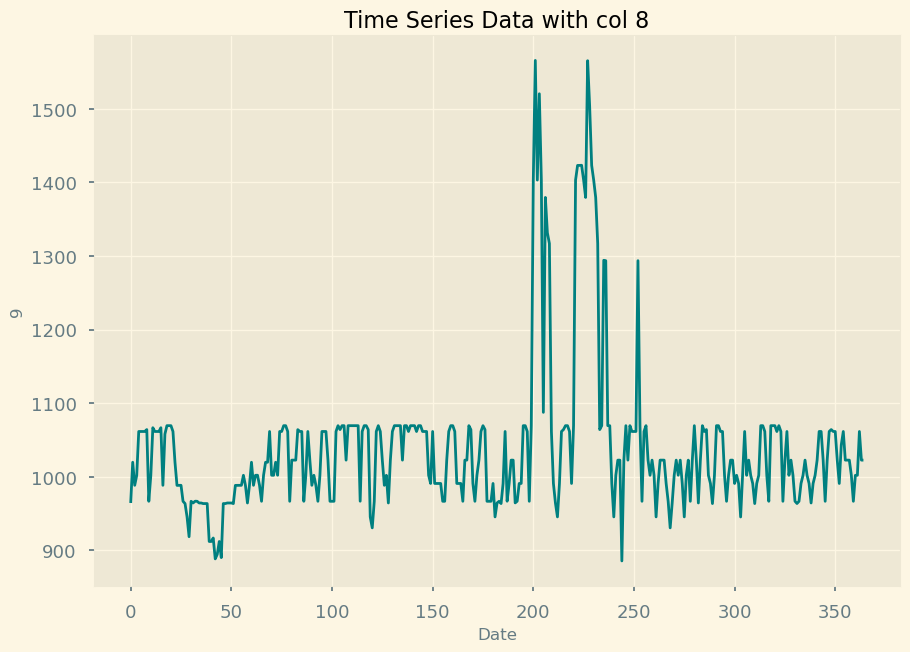

In [375]:
#Biểu đồ trực quan hóa dữ liệu theo ngày
data.set_index('Ngày')
plt.plot(data.index,data['8'], color = "#008080")
plt.title('Time Series Data with col 8')
plt.xlabel('Date')
plt.ylabel('9')
plt.show()


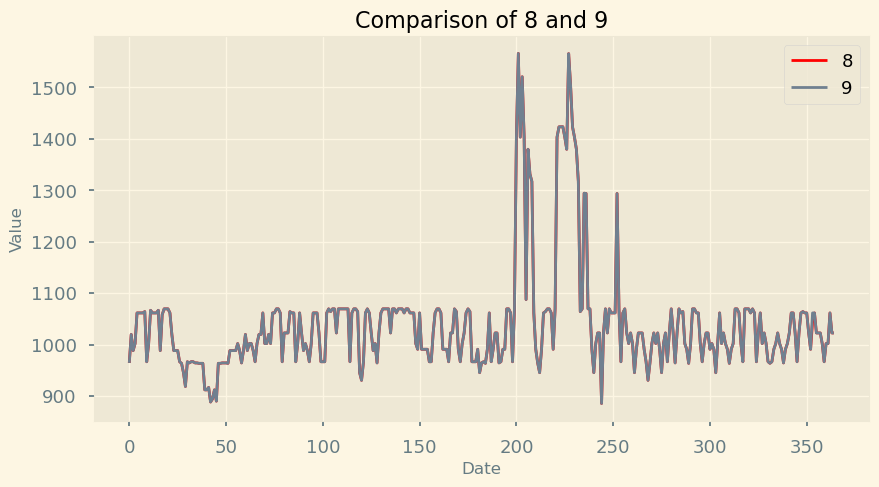

In [376]:
plt.figure(figsize=(10,5))
plt.plot(data['8'],color = 'red',label = '8')
plt.plot(data['9'],color = '#708090',label = '9')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Comparison of 8 and 9')
plt.legend()
plt.show()

BGM+PCA

In [377]:
feats = ['8', '9']
transformer = PowerTransformer()
X=transformer.fit_transform(data[feats])

In [378]:
pca = PCA(n_components=2,random_state=1)
pca.fit(X)
PCA_ds = pd.DataFrame(pca.transform(data[feats]), columns=(["col1","col2"]))
PCA_ds.describe().T

c:\Users\84936\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


,count,mean,std,min,25%,50%,75%,max
col1,365.0,-1404.276703,141.944842,-2113.311287,-1432.947896,-1380.435722,-1334.268206,-1195.630666
col2,365.0,-438.474832,44.325211,-659.921133,-447.464889,-431.066976,-416.650302,-373.358127


In [379]:
BGM = BayesianGaussianMixture(n_components=7,covariance_type='full',random_state=1,n_init=15)
# fit model and predict clusters
preds = BGM.fit_predict(X)

#Adding the Clusters feature to the orignal dataframe.
data["Clusters"]= preds

c:\Users\84936\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\84936\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\84936\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\84936\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Window

In [380]:
pp=BGM.predict_proba(X)# Calcualting the probabilities of each prediction
df_new=pd.DataFrame(X,columns=feats) 
df_new[[f'predict_proba_{i}' for i in range(7)]]=pp # creating new dataframe columns of probabilites 
df_new['preds']=preds
df_new['predict_proba']=np.max(pp,axis=1)
df_new['predict']=np.argmax(pp,axis=1)
    
train_index=np.array([])
for n in range(7):
    n_inx=df_new[(df_new.preds==n) & (df_new.predict_proba > 0.68)].index
    train_index = np.concatenate((train_index, n_inx))

In [381]:
X_new=df_new.loc[train_index][feats]
y=df_new.loc[train_index]['preds']

params_lgb = {'learning_rate': 0.06,'objective': 'multiclass','boosting': 'gbdt','n_jobs': -1,'verbosity': -1, 'num_classes':7} 

model_list=[]

gkf = StratifiedKFold(11)
for fold, (train_idx, valid_idx) in enumerate(gkf.split(X_new,y)):   

    tr_dataset = lgb.Dataset(X_new.iloc[train_idx],y.iloc[train_idx],feature_name = feats)
    vl_dataset = lgb.Dataset(X_new.iloc[valid_idx],y.iloc[valid_idx],feature_name = feats)
    
    model = lgb.train(params = params_lgb, 
                train_set = tr_dataset, 
                valid_sets =  vl_dataset, 
                num_boost_round = 5000, 
                callbacks=[ lgb.early_stopping(stopping_rounds=300, verbose=False), lgb.log_evaluation(period=200)])  
    
    model_list.append(model)

[200]	valid_0's multi_logloss: 6.66134e-15
[200]	valid_0's multi_logloss: 6.66134e-15
[200]	valid_0's multi_logloss: 6.66134e-15
[200]	valid_0's multi_logloss: 6.66134e-15
[200]	valid_0's multi_logloss: 6.66134e-15
[200]	valid_0's multi_logloss: 6.66134e-15
[200]	valid_0's multi_logloss: 6.66134e-15
[200]	valid_0's multi_logloss: 6.66134e-15
[200]	valid_0's multi_logloss: 6.66134e-15
[200]	valid_0's multi_logloss: 6.66134e-15
[200]	valid_0's multi_logloss: 6.66134e-15


ARIMA

In [382]:
lgb_preds=0
for model in model_list:
    lgb_preds+=model.predict(df_new[feats])

In [383]:
labels=np.argmax(lgb_preds,axis=1)

In [384]:
print('ADF Statistic : %f' %adfuller(data['8'])[0])
print('p-values: %f'%adfuller(data['8'])[1])

ADF Statistic : -2.784759
p-values: 0.060484


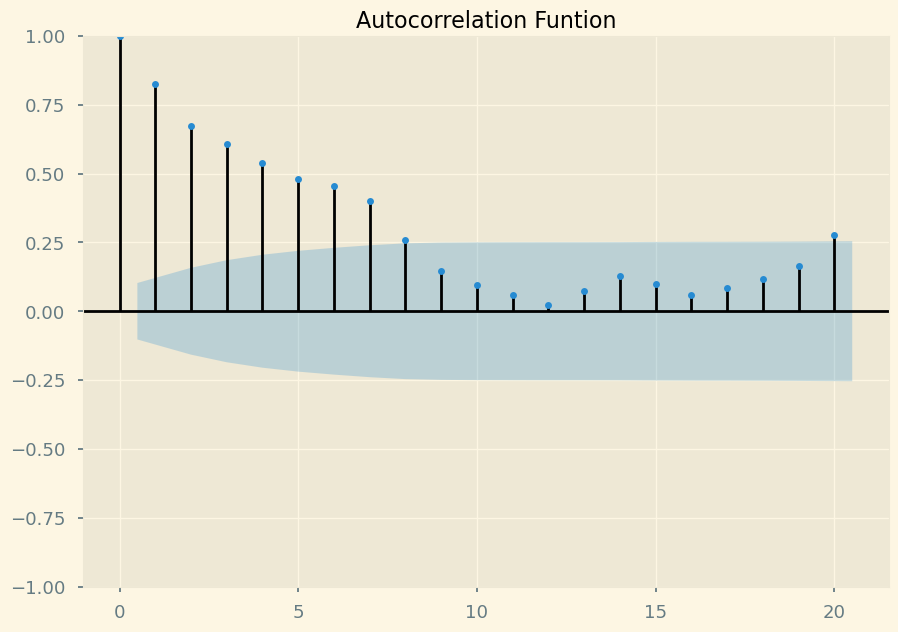

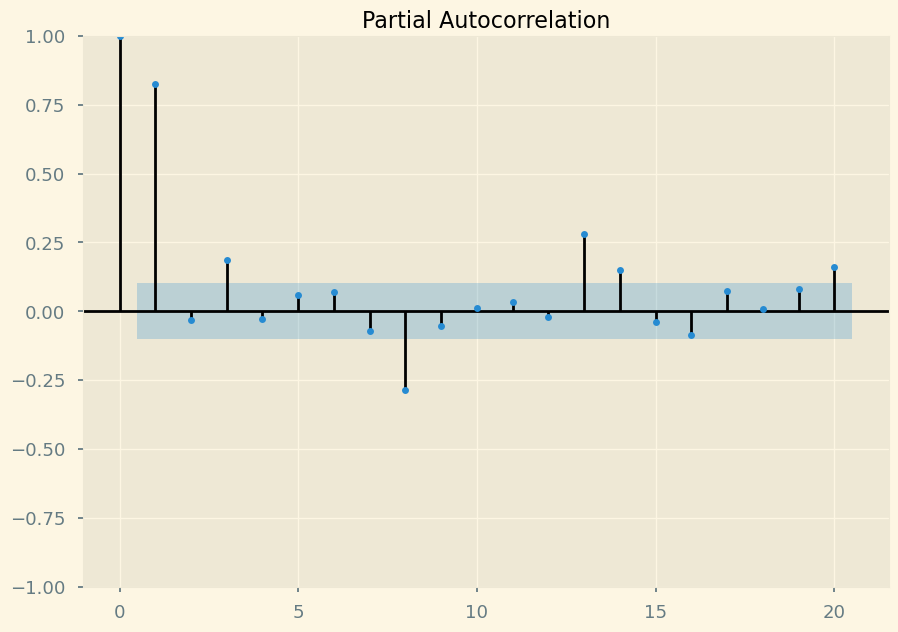

In [385]:
plot_acf(data['9'],lags =20)
plt.title('Autocorrelation Funtion')
plt.show()

plot_pacf(data['9'],lags =20)
plt.title('Partial Autocorrelation')
plt.show()

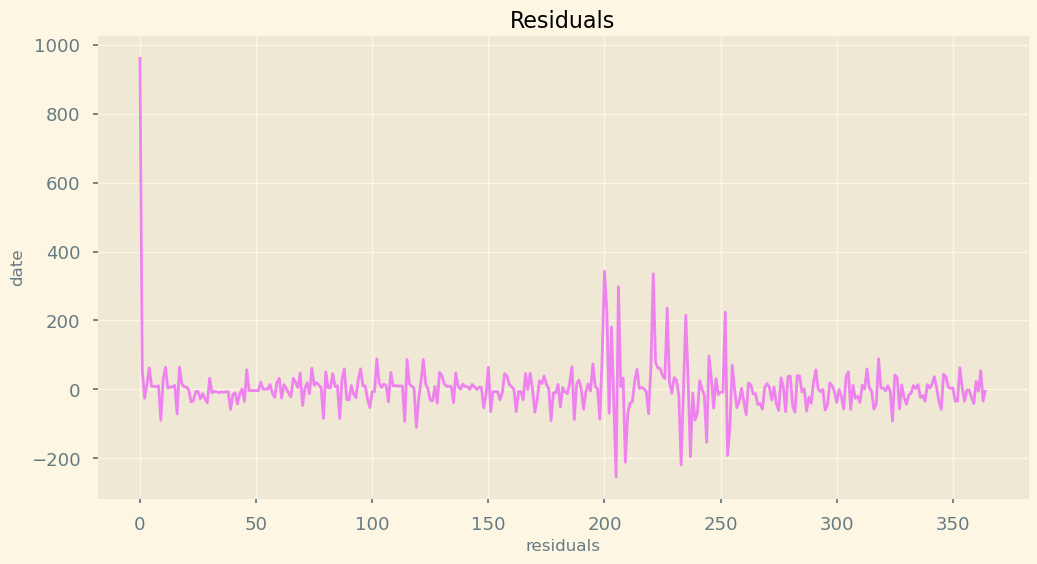

In [386]:
model = ARIMA(data['9'],order =(1,1,1))
model = model.fit()

plt.figure(figsize = (12,6))
residuals = model.resid
plt.plot(residuals, color = "violet")
plt.xlabel('residuals')
plt.ylabel('date')
plt.title('Residuals')
plt.show()

In [387]:
print('ADF Statistic : %f' %adfuller(residuals)[0])
print('p-values: %f'%adfuller(residuals)[1])

ADF Statistic : -5.256369
p-values: 0.000007


ADF Statistic: -9.347810
p-value: 0.000000
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571


<Figure size 800x600 with 0 Axes>

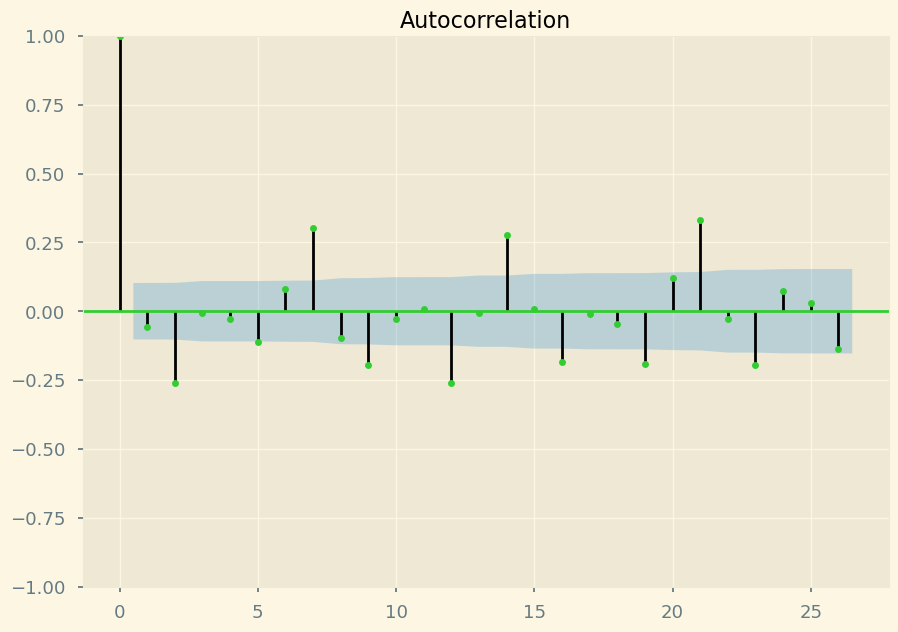

In [388]:
col_index = 8
r_t = np.log(data.iloc[:, col_index] / data.iloc[:, col_index].shift(1)).values

mean = np.nanmean(r_t)
r_t[0]=mean
r_t[:8]

result = adfuller(r_t)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))
    
plt.figure(figsize = (8, 6))
ax1 = plot_acf(r_t, color = "#32CD32")

<Figure size 800x600 with 0 Axes>

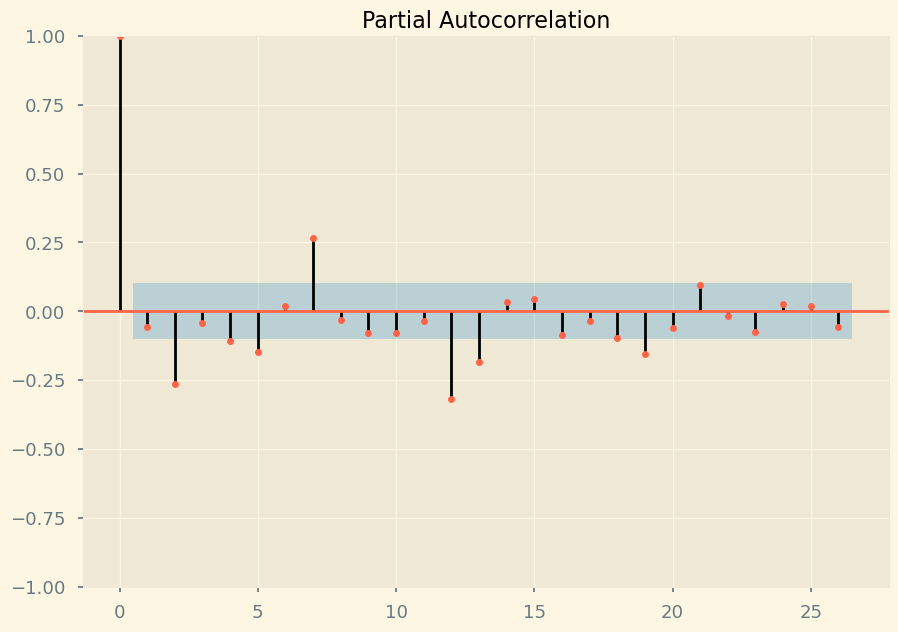

In [389]:
plt.figure(figsize = (8, 6))
ax2 = plot_pacf(r_t, color = "#FF6347")
plt.style.use('Solarize_Light2')

In [390]:
model_arima = ARIMA(r_t, order=(2, 0, 2))
model_fit = model_arima.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  365
Model:                 ARIMA(2, 0, 2)   Log Likelihood                 563.050
Date:                Tue, 14 May 2024   AIC                          -1114.099
Time:                        11:36:43   BIC                          -1090.700
Sample:                             0   HQIC                         -1104.800
                                - 365                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.959e-05      0.001      0.067      0.947      -0.002       0.002
ar.L1         -0.1033      0.063     -1.649      0.099      -0.226       0.020
ar.L2          0.4997      0.057      8.734      0.0

c:\Users\84936\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
